# Getting started

This tutorial will guide you through installing the required libraries for the rest of the tutorials, downloading and accessing the dataset, and loading some data to view.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hassonlab/podcast-ecog-tutorials/blob/main/notebooks/00-intro.ipynb)

## Setup your environment

A full list of required packages are defined in a conda [environment.yml](https://openneuro.org/datasets/ds005574) file. For the purposes of this tutorial, we will only install the required dependencies. You may skip this step if you're an existing environment.

In [ ]:
!pip install nilearn mne mne_bids

Now that the libraries are installed, we will load them.

In [1]:
import mne
import numpy as np
from mne_bids import BIDSPath

## Download the data

For this tutorial, we will download one file from the dataset. To download the entire dataset, see the [how to download](https://openneuro.org/datasets/ds005574/download) page.

Because the dataset is structured according to [BIDS](https://bids-specification.readthedocs.io/en/stable/) conventions, we can use the `BIDSPath` class to define the path components and construct a path. For simplificty, we will load the preprocessed ECoG data from the dataset. This file exists under the `derivatives/ecogprep/` directory, and has the name `sub-0*_task-podcast_desc-highgamma_ieeg.fif`. The `fif` extension signifies this is an MNE format that contains the data and metadata in one file.

In [2]:
file_path = BIDSPath(root="derivatives/ecogprep",
                     subject="02",
                     task="podcast",
                     datatype="ieeg",
                     description="highgamma",
                     suffix="ieeg",
                     extension="fif")
print(f"File path within the dataset: {file_path}")

File path within the dataset: derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif


Now we can download the file using `wget`:

In [3]:
!wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$file_path

File ‘sub-02_task-podcast_desc-highgamma_ieeg.fif’ already there; not retrieving.



## Verify dataset

Now that we have the dependencies installed and the data file downloaded, we'll load it using the [MNE](https://mne.tools/) library. 
We'll be using `MNE` throughout the tutorials. To load the data file we downloaded, we'll use the `read_raw_fif` function, and then display some of the metadata about the file.

In [4]:
raw = mne.io.read_raw_fif(file_path.basename, verbose=False)
raw

<Raw | sub-02_task-podcast_desc-highgamma_ieeg.fif, 90 x 921600 (1800.0 s), ~108 kB, data not loaded>

The output contains several important pieces of information. First, duration of the data is roughly 30 minutes long (corresponding to the length of the podcast). The data is sampled at 512 Hz. There are 90 ECoG channels. And the data has a filtered applied to it ranging from 70 Hz to 200 Hz.

One of the primary MNE classes is the [Raw](https://mne.tools/stable/generated/mne.io.Raw.html). It has many useful methods and properties if you look at its documentation. The two we will mention now are `get_data()` and the `info` attribute. Sometimes we want to work with the underlying data directly. Here is how:

In [5]:
data = raw.get_data()
print(f"Data is a {type(data)} object and has a shape of: {data.shape}")

Data is a <class 'numpy.ndarray'> object and has a shape of: (90, 921600)


We notice that the data is a NumPy object (a nearly universal way of working with numerical data in python), and its a matrix with two dimensions. The first dimension corresponds to the number of channels—90, as we saw before— and the second is the total number of samples.

`raw.info` returns an [Info](https://mne.tools/stable/generated/mne.Info.html) object. We saw this information earlier as it contains much of the metadata of the file. Particularly useful are the information we can get on those 90 channels. This can be accessed by `raw.info.ch_names` and `raw.info.chs`. The documentation spells out the details very clearly. Below, we'll use the channel information to get electrode locations and plot them on a brain.

For example, let's look at just the first electrode.

In [6]:
print("First channel name is:", raw.info.ch_names[0])
print("Metadata associated with the first channel:")
raw.info['chs'][0]

First channel name is: PO1
Metadata associated with the first channel:


{'scanno': 1,
 'logno': 1,
 'kind': 902 (FIFFV_ECOG_CH),
 'range': 1.0,
 'cal': 1.0,
 'coil_type': 1 (FIFFV_COIL_EEG),
 'loc': array([-0.06466667, -0.051     , -0.01066667,  0.        ,  0.        ,
         0.        ,         nan,         nan,         nan,         nan,
                nan,         nan]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'PO1',
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

The `loc` key in the dictionary gives us the 3D coordinates (x, y, and z) that localize the electrode in brain space.

## Ploting electrodes on the brain

Now we'll use a library called [nilearn](https://nilearn.github.io/) to help us plot the electrodes on a glass brain. We'll be using the function [plot_markers](https://nilearn.github.io/stable/modules/generated/nilearn.plotting.plot_markers.html). Take a quick look at its parameters in the documentation, as they can be very useful.

In [7]:
from nilearn.plotting import plot_markers

At a minimum, this function requires a set of values, and a corresponding set of coordinates. The coordinates tell `nilearn` _where_ to plot the electrode, while the value tells it what color to assign it. For the example below, we just want to plot them all in one color, so values will be all the same number. Importantly, we need to collate the coordinates into a NumPy matrix of shape `(n, 3)` where `n` is the number of electrodes and the 3 columns are the coordinates of each electrode. First, we'll assemble this matrix:

In [8]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

Coordinate matrix shape:  (90, 3)


And now we plot them on the brain:

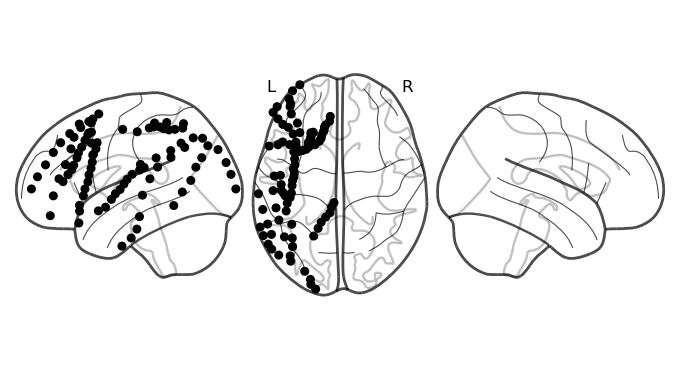

In [9]:
values = np.ones(len(coords))
fig = plot_markers(values, coords,
             node_size=30, display_mode='lzr', alpha=1,
             node_cmap='Grays', colorbar=False, node_vmin=0, node_vmax=1)
print(fig)